# **Introduction**

### Earthquake Dataset Overview

- This dataset contains seismic observations of earthquake events recorded globally. Each row represents a specific earthquake, capturing key attributes related to its geographical location, intensity, and depth. The objective is to analyze earthquake trends and characteristics, as well as to explore relationships between the features.

### Feature Descriptions

- **Focal depth** (numeric): The depth at which the earthquake occurred (measured in kilometers).
- **Latitude** (numeric): The latitude coordinate of the earthquake's epicenter.
- **Longitude** (numeric): The longitude coordinate of the earthquake's epicenter.
- **Richter** (numeric): The magnitude of the earthquake measured on the Richter scale.


# **Importing Libraries**

Lets first import all the sufficiencies

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='viridis')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score, \
                            normalized_mutual_info_score, v_measure_score, fowlkes_mallows_score

from sklearn.model_selection import GridSearchCV

import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# **EDA and Data Preprocessing**

Now lets dive into our dataset and make some discoveries

In [ ]:
df = pd.read_csv('/content/quake.csv')

In [ ]:
df.head().T

,0,1,2,3,4
Focal depth,33.00,36.00,57.00,67.00,30.00
Latitude,-52.26,45.53,41.85,29.19,-21.66
Longitude,28.30,150.93,142.78,141.15,169.81
Richter,6.70,5.80,5.80,6.20,6.00


In [ ]:
df.shape

(2178, 4)

So we have data with 4 features and 2178 instances, which could be considered as a small dataset

In [ ]:
df.dtypes

,0
Focal depth,int64
Latitude,float64
Longitude,float64
Richter,float64


All of our features are numeric

In [ ]:
missing_df = df.isnull().sum().to_frame().rename(columns={0:"No. of Missing Values"})

missing_df["% of Missing Values"] = round((missing_df["No. of Missing Values"]/len(df))*100,2)

missing_df

,No. of Missing Values,% of Missing Values
Focal depth,0,0.0
Latitude,0,0.0
Longitude,0,0.0
Richter,0,0.0


As you can see we don't have any missing values in our dataset

In [ ]:
df.nunique()

,0
Focal depth,312
Latitude,1824
Longitude,1958
Richter,12


Here we can see the number of unique values, which seem quite reasonable at the first glance.

Now lets visualize our data and explore it even better

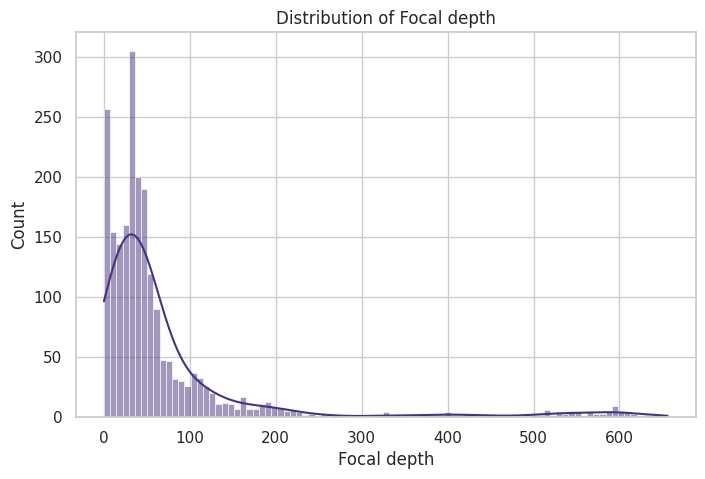

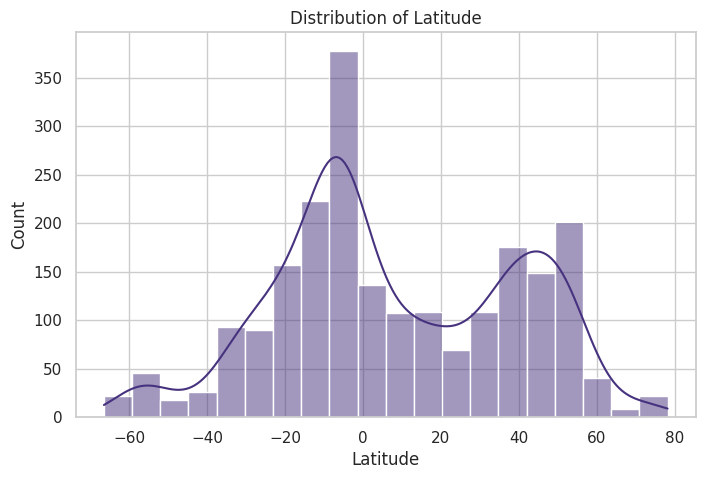

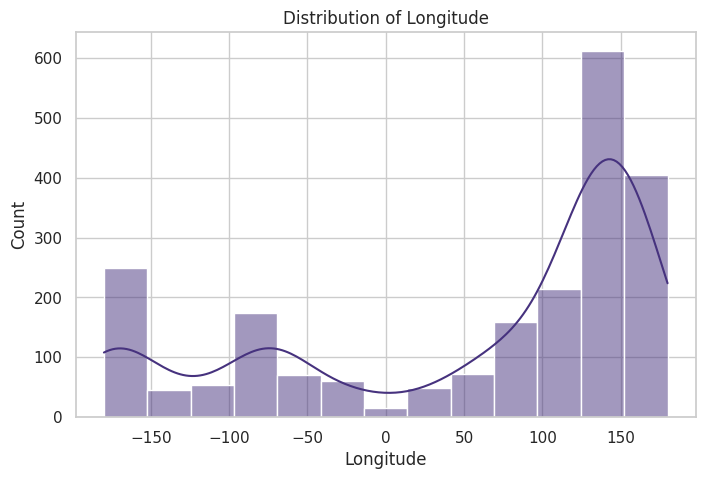

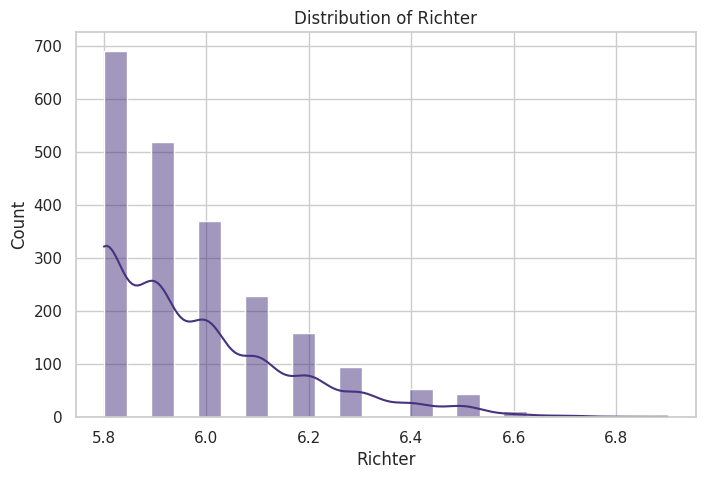

In [ ]:
for column in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')

So pretty much all of them seem to be reasonable. Richter and Focal depth features seeem to have positively skewed distributions, which is pretty explenatory, because earthquakes with higher Focal depth and magnitude are less occurances, and about the Longitude and Latitude they are just locations which could be random, indicating the highly seismic geographical areas

Now we have to check the dataset's outliers because from the distributions they are expected to occur.

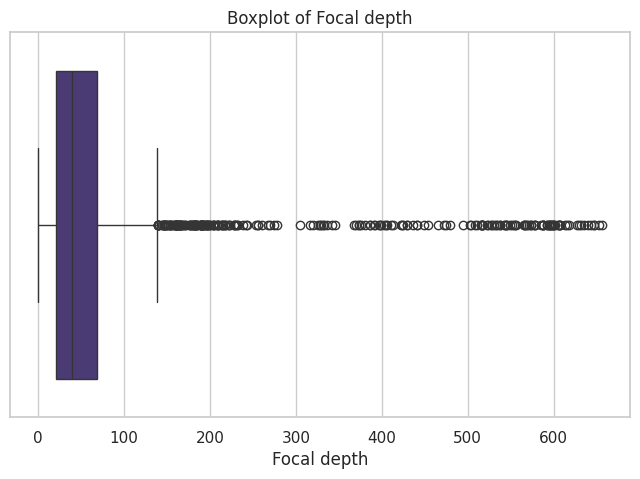

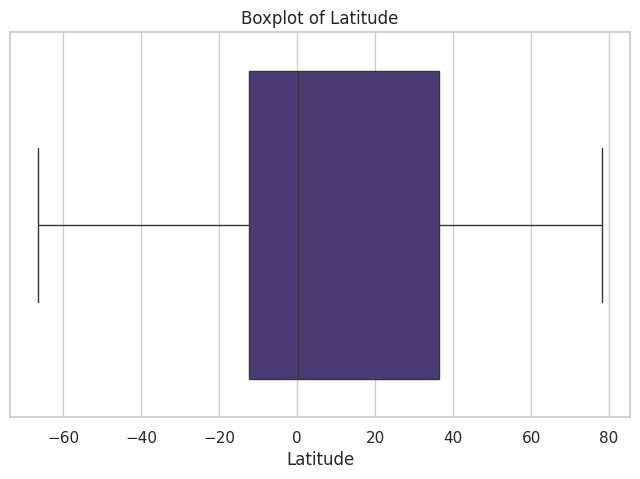

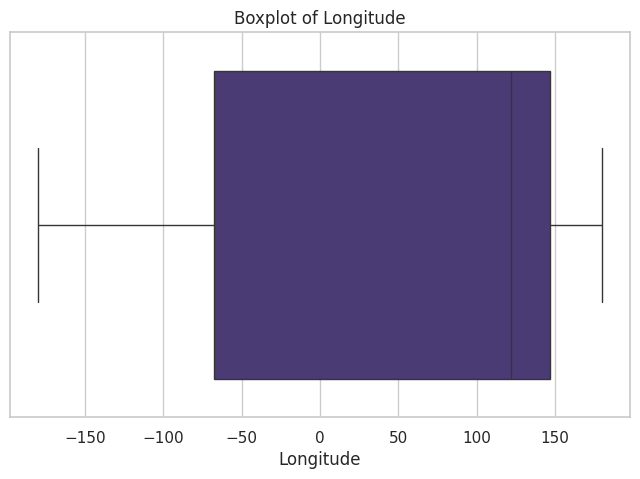

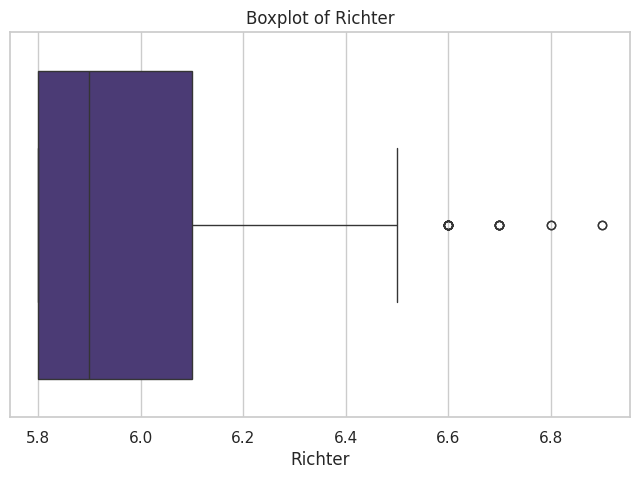

In [ ]:
for column in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

So as we expected our Ritcher and Focal depth variables seem to have quite decent amount of outliers according to the boxplots, especially the Focal depth variable. We can use the domain knowledge here to explain the situation. According to the internet, earthquakes with the focal depth between 70 and 300 Kms are considered the most common ones and called the mid-focus earthquakes, the ones that have a focal depth between 300 and 700 Kms are called deep-focus earthquakes, which are not that common, but for high seismic areas they are not that unusual. So it means that focal depth can be varying somewhere between 70-700 and we should not consider them as outliers only because they don't accure that much

About the Richter variable. According to internet, earthquakes with magnitudes of around 2-5 richter are really common and occur pretty often during the year. The earthquakes with magnitude from 5-7 are much less usual, but still they happen 1000-1500 times per year, so we can't be removing them for our clustering because we might lose some good insights and maybe even some little clusters. The only issue we might come across is about K-means clustering, because they are highly sensitive to number of centroids and thus they are sensitive to outliers, so it would give us pretty bad results so we have to be careful and play around with our number of clusters and see the changes. Other than that these outliers won't change much for other algorithms.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

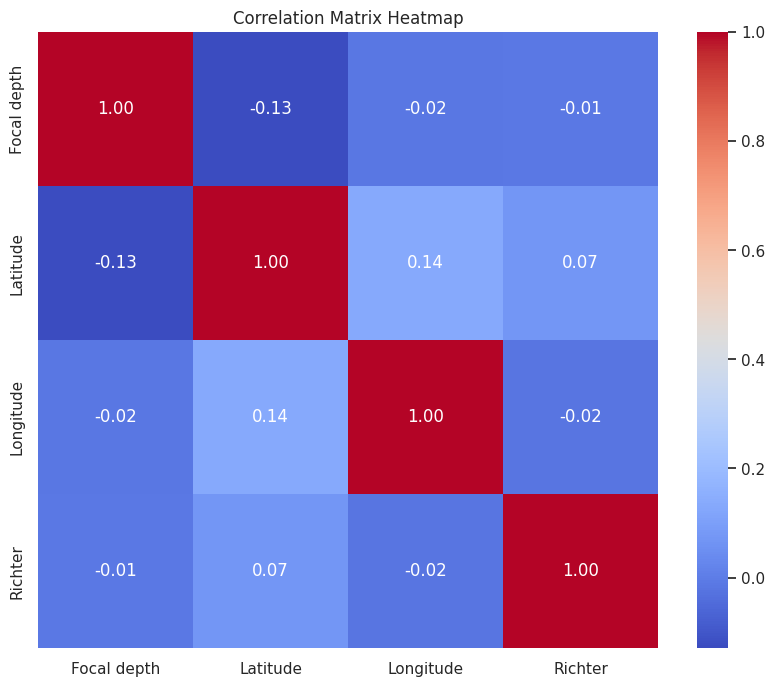

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Heatmap")

There is not some serious correlation between any of the variables

Since we done with all the discoveries and know our dataset well, we can prepare our data for further modelings and scale them. I am scaling the data with StandardScaler to make sure each feature has a mean of 0 and a standard deviation of 1. This is important for clustering algorithms like K-means, as it prevents features with larger ranges from dominating the clustering process and ensures all features are treated equally

In [ ]:
df_original = df.copy()

scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df.head().T

,0,1,2,3,4
Focal depth,-0.355201,-0.329437,-0.149088,-0.063208,-0.380965
Latitude,-1.971998,1.230182,1.109679,0.695121,-0.969986
Longitude,-0.223940,0.807880,0.739305,0.725590,0.966738
Richter,3.816707,-0.935570,-0.935570,1.176553,0.120492


# **Model Building and Evaluation**

## **K-Means Clustering**

Since we have our data fully discovered and preprocessed now we can start clustering it with various methods and discover some new insights

First lets make a simple K-means clustering with a 15 clusters and visualize it using PCA

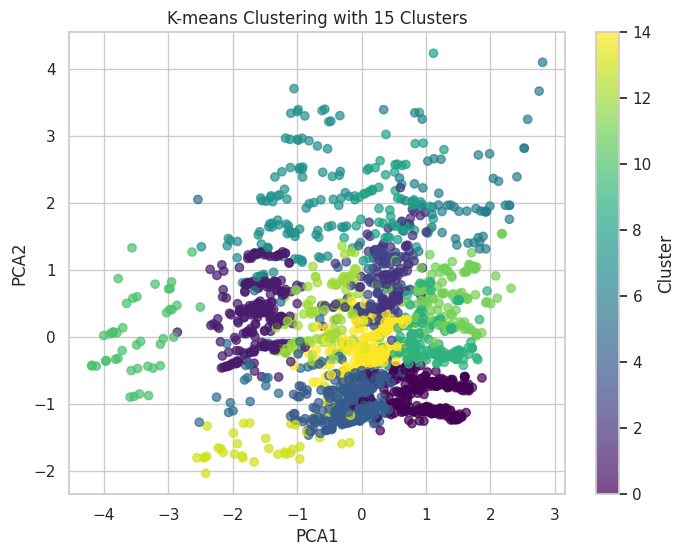

In [ ]:
random_state = 123
kmeans = KMeans(n_clusters=15, random_state=random_state)
df['Cluster'] = kmeans.fit_predict(df)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.drop('Cluster', axis=1))

df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.title('K-means Clustering with 15 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')

So as we see not the best results because of our randomly chosen Ks, now lets find the optimal number of clusters using 2 different methods, Elbow method and Silhouette Score, visualize both of them and see what number of Ks would they give us

Text(0, 0.5, 'Inertia')

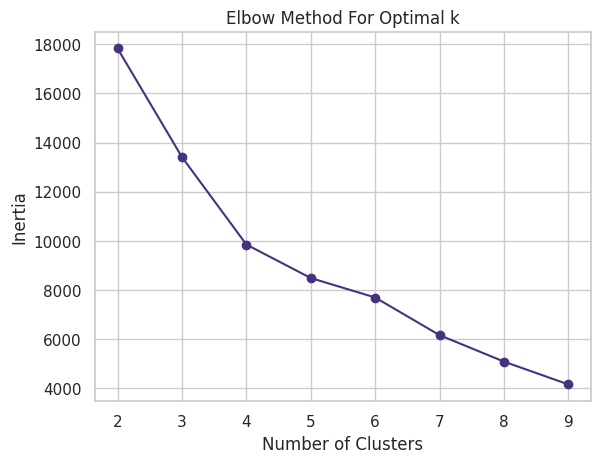

In [ ]:
inertia = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(df)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

In [ ]:
cluster_range = range(2, 10)

silhouette_scores = {}

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(df)

    sil_score = silhouette_score(df, kmeans.labels_)

    silhouette_scores[k] = sil_score

sorted_scores = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

for k, score in sorted_scores:
    print(f"Number of Clusters: {k}, Silhouette Score: {score}")

Number of Clusters: 2, Silhouette Score: 0.5728204671492255
Number of Clusters: 9, Silhouette Score: 0.5574633066320157
Number of Clusters: 8, Silhouette Score: 0.5377319356750379
Number of Clusters: 7, Silhouette Score: 0.5180851277094756
Number of Clusters: 6, Silhouette Score: 0.4923440923849286
Number of Clusters: 5, Silhouette Score: 0.4625730996359687
Number of Clusters: 3, Silhouette Score: 0.437814736059516
Number of Clusters: 4, Silhouette Score: 0.421241662896388


So based on the Elbow method the optimal number of clusters is 4, but according to Silhouette score it's 2. They have their advantages and disadvantages, but before choosing our optimal value between 2 or 4, lets plot the clustered data with both number of Ks and base our decision on the visualization clearance

Text(0.5, 0, 'PCA1')

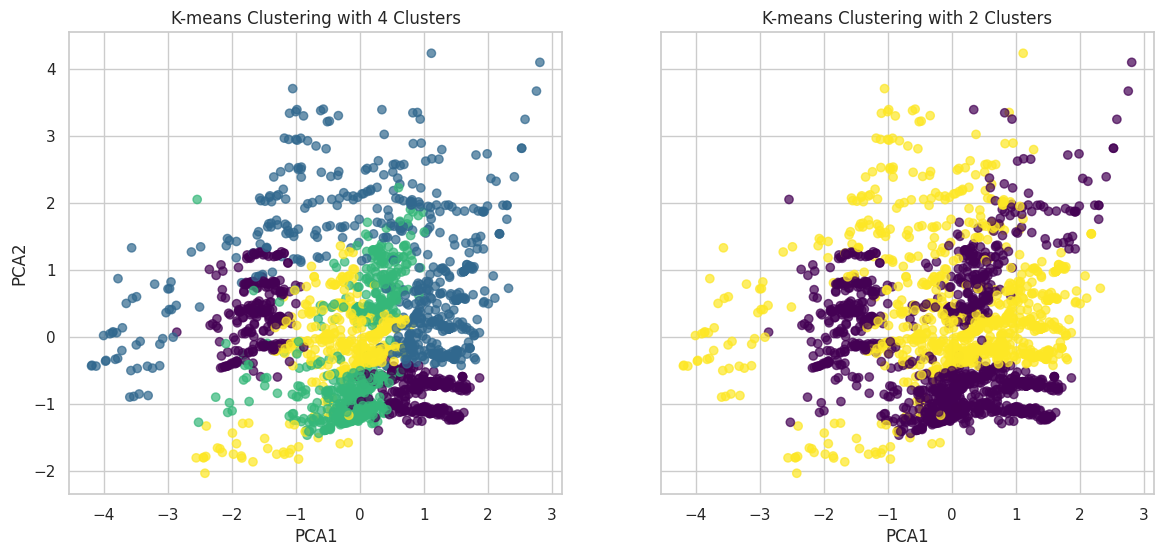

In [ ]:
kmeans_4 = KMeans(n_clusters=4, random_state=random_state)
df['Cluster_K4'] = kmeans_4.fit_predict(df)

kmeans_2 = KMeans(n_clusters=2, random_state=random_state)
df['Cluster_K2'] = kmeans_2.fit_predict(df)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(df_pca['PCA1'], df_pca['PCA2'], c=df['Cluster_K4'], cmap='viridis', alpha=0.7)
axes[0].set_title('K-means Clustering with 4 Clusters')
axes[0].set_xlabel('PCA1')
axes[0].set_ylabel('PCA2')

axes[1].scatter(df_pca['PCA1'], df_pca['PCA2'], c=df['Cluster_K2'], cmap='viridis', alpha=0.7)
axes[1].set_title('K-means Clustering with 2 Clusters')
axes[1].set_xlabel('PCA1')

So it is quite unclear which one is better and which evaluation metric to trust, in this case I think it is better to follow the elbow method and thoose the one with the less inertia, which is 4 number of clusters. I chose the 4 not only cause inertia, but I think that more numbers of clusters would be more suitable for our number of data points and location diversity

## **MiniBatchKmeans Clustering**

Now lets apply MiniBatchKMeans to cluster our dataset and compare the results. MiniBatchKMeans is a faster variant of KMeans because it uses small batches of the dataset at a time, rather than using the entire dataset for each update during the clustering process

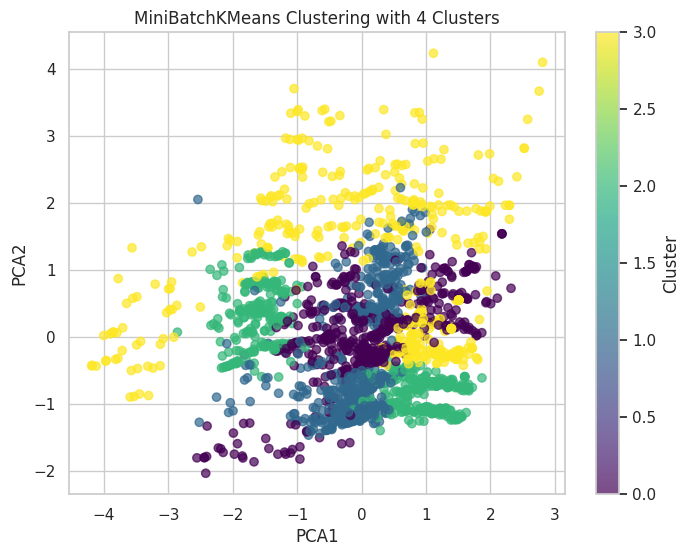

In [ ]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=4, random_state=random_state)
df['Cluster_MiniBatch_K4'] = minibatch_kmeans.fit_predict(df)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df['Cluster_MiniBatch_K4'], cmap='viridis', alpha=0.7)
plt.title('MiniBatchKMeans Clustering with 4 Clusters')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')

As expected MiniBatchKmeans yielded pretty much the same results based on the 2D plot, lets not compare this two based on their evaluation metrics

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=77)
kmeans_labels = kmeans.fit_predict(df)

minibatch_kmeans = MiniBatchKMeans(n_clusters=3, random_state=77)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(df)

silhouette_kmeans = silhouette_score(df, kmeans_labels)
silhouette_minibatch_kmeans = silhouette_score(df, minibatch_kmeans_labels)

inertia_kmeans = kmeans.inertia_
inertia_minibatch_kmeans = minibatch_kmeans.inertia_

calinski_kmeans = calinski_harabasz_score(df, kmeans_labels)
calinski_minibatch_kmeans = calinski_harabasz_score(df, minibatch_kmeans_labels)


ari_minibatch_kmeans = adjusted_rand_score(kmeans_labels, minibatch_kmeans_labels)
nmi_minibatch_kmeans = normalized_mutual_info_score(kmeans_labels, minibatch_kmeans_labels)
fmi_minibatch_kmeans = fowlkes_mallows_score(kmeans_labels, minibatch_kmeans_labels)

print("Internal Evaluation Metrics:\n")

print(f"KMeans Silhouette Score: {silhouette_kmeans}")
print(f"MiniBatchKMeans Silhouette Score: {silhouette_minibatch_kmeans}")
print(f"KMeans Inertia: {inertia_kmeans}")
print(f"MiniBatchKMeans Inertia: {inertia_minibatch_kmeans}")
print(f"KMeans Calinski-Harabasz Index: {calinski_kmeans}")
print(f"MiniBatchKMeans Calinski-Harabasz Index: {calinski_minibatch_kmeans}")

print("\nExternal Evaluation Metrics (using KMeans labels as ground truth):\n")

print(f"MiniBatchKMeans Adjusted Rand Index: {ari_minibatch_kmeans}")
print(f"MiniBatchKMeans Normalized Mutual Information: {nmi_minibatch_kmeans}")
print(f"MiniBatchKMeans Fowlkes-Mallows Index: {fmi_minibatch_kmeans}")

import warnings
warnings.filterwarnings("ignore")

Internal Evaluation Metrics:

KMeans Silhouette Score: 0.41412491209119406
MiniBatchKMeans Silhouette Score: 0.44675322787529315
KMeans Inertia: 16917.150746596195
MiniBatchKMeans Inertia: 16593.20872884549
KMeans Calinski-Harabasz Index: 2782.226367138744
MiniBatchKMeans Calinski-Harabasz Index: 2858.01209063815

External Evaluation Metrics (using KMeans labels as ground truth):

MiniBatchKMeans Adjusted Rand Index: 0.5021893643495793
MiniBatchKMeans Normalized Mutual Information: 0.5920097448759514
MiniBatchKMeans Fowlkes-Mallows Index: 0.6751717676232574


The results show that MiniBatchKMeans slightly outperforms KMeans in most metrics. MiniBatchKMeans achieves better internal evaluation metrics, such as Silhouette Score and Calinski-Harabasz Index, suggesting more compact and well-separated clusters. For external evaluation metrics, MiniBatchKMeans also performs better in metrics like Adjusted Rand Index, Normalized Mutual Information, and Fowlkes-Mallows Index, indicating a closer alignment with the ground truth. These findings highlight that MiniBatchKMeans can provide comparable or superior clustering performance with the added advantage of faster computation, making it more efficient for large datasets

## **DBSCAN**

Since we built, tuned, visualized and evaluated both K-means and MiniBatchKmeans clustering algorithms, and they both turned out identical making the MiniBatch version more efficient and desirable, now lets move on and use other different clustering algorithms starting with DBSCAN

DBSCAN eps=0.3, min_samples=3, silhouette_score=0.144
DBSCAN eps=0.3, min_samples=5, silhouette_score=0.052
DBSCAN eps=0.3, min_samples=7, silhouette_score=0.018
DBSCAN eps=0.5, min_samples=3, silhouette_score=0.170
DBSCAN eps=0.5, min_samples=5, silhouette_score=0.127
DBSCAN eps=0.5, min_samples=7, silhouette_score=0.075
DBSCAN eps=0.7, min_samples=3, silhouette_score=0.529
DBSCAN eps=0.7, min_samples=5, silhouette_score=0.598
DBSCAN eps=0.7, min_samples=7, silhouette_score=0.590


Text(0, 0.5, 'PCA Component 2')

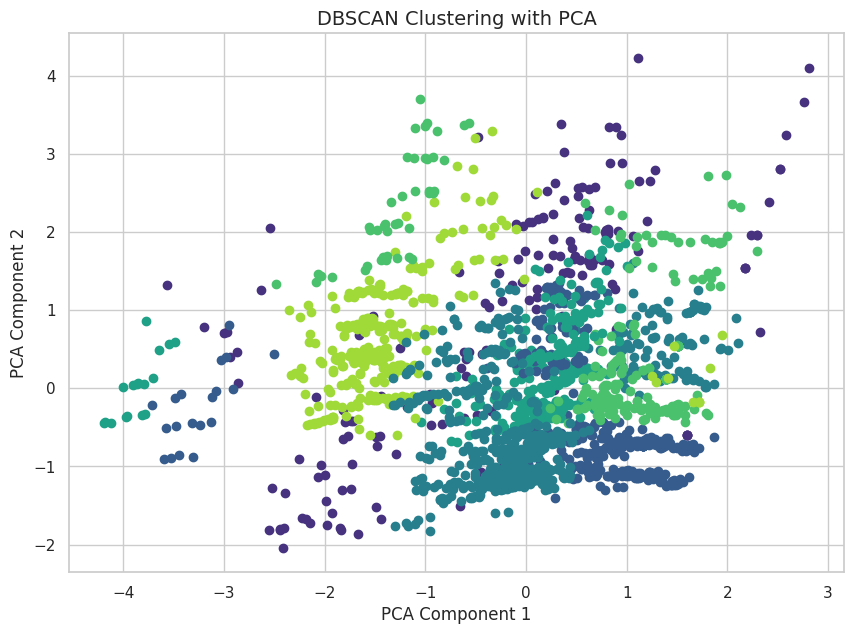

In [ ]:
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 5, 7]

best_dbscan_score = -1
best_dbscan_model = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(df)

        if len(set(dbscan_labels)) <= 1:
            continue

        silhouette_avg = silhouette_score(df, dbscan_labels)
        print(f"DBSCAN eps={eps}, min_samples={min_samples}, silhouette_score={silhouette_avg:.3f}")

        if silhouette_avg > best_dbscan_score:
            best_dbscan_score = silhouette_avg
            best_dbscan_model = dbscan

best_dbscan_labels = best_dbscan_model.fit_predict(df)

df_pca = np.array(df_pca)

plt.figure(figsize=(10, 7))
unique_labels = np.unique(best_dbscan_labels)

for label in unique_labels:
    label_mask = best_dbscan_labels == label
    plt.scatter(df_pca[label_mask, 0], df_pca[label_mask, 1], label=f"Cluster {label}" if label != -1 else "Noise")

plt.title("DBSCAN Clustering with PCA", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

According to DBSCAN the optimal number of clusters is 20, which is quite a lot. Now lets check our evaluation metrics and use our Kmeans labels as a ground truth

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(df)

silhouette_dbscan = silhouette_score(df, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1
calinski_dbscan = calinski_harabasz_score(df, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

ari_dbscan = adjusted_rand_score(kmeans_labels, dbscan_labels)
nmi_dbscan = normalized_mutual_info_score(kmeans_labels, dbscan_labels)
fmi_dbscan = fowlkes_mallows_score(kmeans_labels, dbscan_labels)

print("Internal Evaluation Metrics:\n")
print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")
print(f"DBSCAN Calinski-Harabasz Index: {calinski_dbscan}")

print("\nExternal Evaluation Metrics (using KMeans labels as ground truth):\n")
print(f"DBSCAN Adjusted Rand Index: {ari_dbscan}")
print(f"DBSCAN Normalized Mutual Information: {nmi_dbscan}")
print(f"DBSCAN Fowlkes-Mallows Index: {fmi_dbscan}")

Internal Evaluation Metrics:

DBSCAN Silhouette Score: 0.12669192294254927
DBSCAN Calinski-Harabasz Index: 275.7195622388064

External Evaluation Metrics (using KMeans labels as ground truth):

DBSCAN Adjusted Rand Index: 0.16130238829809226
DBSCAN Normalized Mutual Information: 0.4394705210791378
DBSCAN Fowlkes-Mallows Index: 0.3480412673483189


The evaluation of DBSCAN clustering shows limited agreement with KMeans labels. The low Silhouette Score indicates poorly separated clusters, while the Calinski-Harabasz Index suggests some structure in the data. External metrics like Adjusted Rand Index and Fowlkes-Mallows Index show weak alignment with KMeans, and the moderate Normalized Mutual Information indicates partial overlap. Overall, DBSCAN may not effectively capture the dataset’s clustering structure compared to KMeans.


## **Agglomerative Clustering**

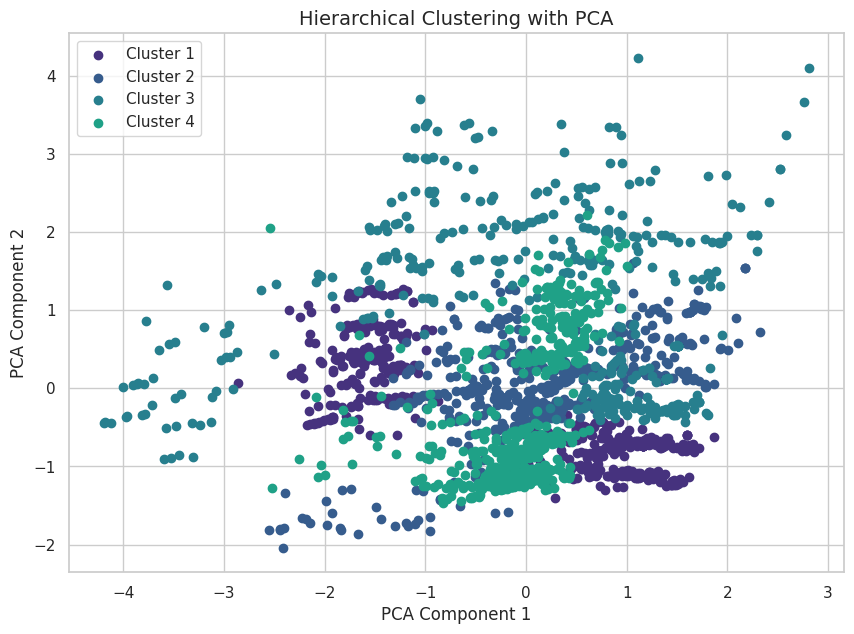

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=4)
hierarchical_labels = hierarchical.fit_predict(df)

plt.figure(figsize=(10, 7))
unique_labels = np.unique(hierarchical_labels)

for label in unique_labels:
    label_mask = hierarchical_labels == label
    plt.scatter(df_pca[label_mask, 0], df_pca[label_mask, 1], label=f"Cluster {label+1}" if label != -1 else "Noise")

plt.title("Hierarchical Clustering with PCA", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

In [ ]:
silhouette_avg = silhouette_score(df, hierarchical_labels)
davies_bouldin_avg = davies_bouldin_score(df, hierarchical_labels)
calinski_harabasz_avg = calinski_harabasz_score(df, hierarchical_labels)

ari = adjusted_rand_score(kmeans_labels, hierarchical_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hierarchical_labels)
fmi = fowlkes_mallows_score(kmeans_labels, hierarchical_labels)

print(f"Internal Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg:.3f}")
print()
print(f"External Metrics (using KMeans labels as ground truth):")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.3f}")

Internal Metrics:
Silhouette Score: 0.506
Davies-Bouldin Index: 0.823
Calinski-Harabasz Index: 3610.920

External Metrics (using KMeans labels as ground truth):
Adjusted Rand Index (ARI): 0.555
Normalized Mutual Information (NMI): 0.670
Fowlkes-Mallows Index (FMI): 0.695


The evaluation of hierarchical clustering with 4 clusters shows moderately well-defined results. The Silhouette Score indicates decent cluster separation, and the Davies-Bouldin Index suggests compact and well-separated clusters. The high Calinski-Harabasz Index supports strong cluster structure. External metrics reveal moderate alignment with KMeans labels, with ARI, NMI, and FMI values indicating reasonable overlap between the two methods. Overall, hierarchical clustering appears to perform reasonably well on the dataset.


Now lets tune our hyperparameters and see how the most optimal results look like

Best hyperparameters: {'linkage': 'complete', 'metric': 'euclidean', 'n_clusters': 2}


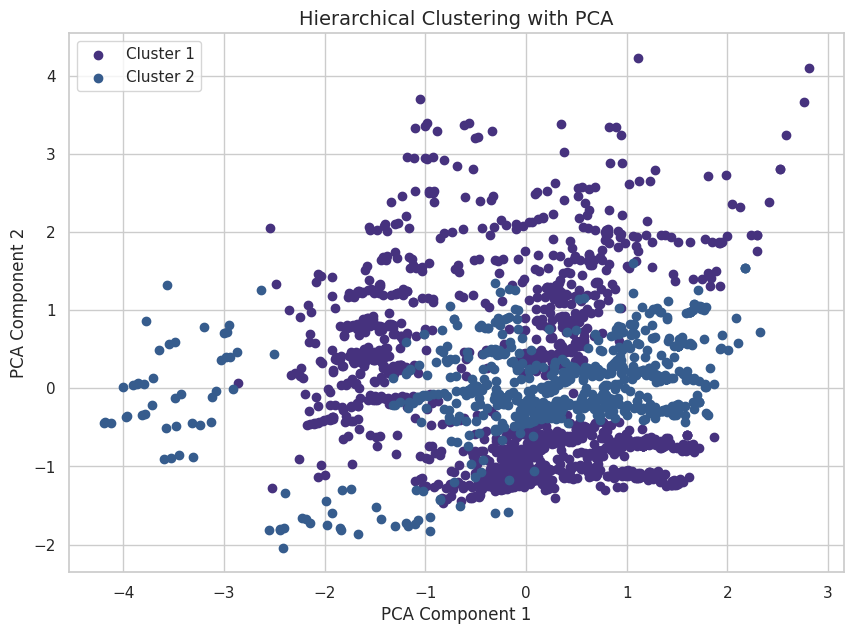

In [ ]:
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

grid_search = GridSearchCV(AgglomerativeClustering(), param_grid, cv=3, scoring=silhouette_scorer)
grid_search.fit(df_pca)

best_params = grid_search.best_params_

best_model = AgglomerativeClustering(n_clusters=best_params['n_clusters'],
                                      linkage=best_params['linkage'],
                                      metric=best_params['metric'])
best_labels = best_model.fit_predict(df_pca)

plt.figure(figsize=(10, 7))
unique_labels = np.unique(best_labels)

for label in unique_labels:
    label_mask = best_labels == label
    plt.scatter(df_pca[label_mask, 0], df_pca[label_mask, 1], label=f"Cluster {label+1}" if label != -1 else "Noise")

plt.title("Hierarchical Clustering with PCA", fontsize=14)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()

print("Best hyperparameters:", best_params)

In [ ]:
silhouette_avg = silhouette_score(df, best_labels)
davies_bouldin_avg = davies_bouldin_score(df, best_labels)
calinski_harabasz_avg = calinski_harabasz_score(df, best_labels)

ari = adjusted_rand_score(kmeans_labels, best_labels)
nmi = normalized_mutual_info_score(kmeans_labels, best_labels)
fmi = fowlkes_mallows_score(kmeans_labels, best_labels)

print(f"Internal Metrics:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_avg:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_avg:.3f}")
print()
print(f"External Metrics (using KMeans labels as ground truth):")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
print(f"Fowlkes-Mallows Index (FMI): {fmi:.3f}")

Internal Metrics:
Silhouette Score: 0.532
Davies-Bouldin Index: 0.711
Calinski-Harabasz Index: 3398.769

External Metrics (using KMeans labels as ground truth):
Adjusted Rand Index (ARI): 0.378
Normalized Mutual Information (NMI): 0.497
Fowlkes-Mallows Index (FMI): 0.662


The evaluation of the tuned hierarchical clustering with 2 clusters shows moderately good results. The Silhouette Score indicates fairly well-separated clusters, while the low Davies-Bouldin Index reflects compact and distinct cluster formation. The high Calinski-Harabasz Index further supports the presence of strong cluster structure. However, external metrics reveal moderate alignment with KMeans labels, with ARI and NMI suggesting partial overlap, while FMI indicates relatively better agreement. Overall, the tuned hierarchical clustering performs reasonably but does not align strongly with KMeans labels.

# **Model Comparison**

Ultimately to conclude, MiniBatchKMeans emerges as the most effective clustering method for this dataset, showing the best performance in both internal and external evaluation metrics. Its high Silhouette Score, Calinski-Harabasz Index, and low inertia indicate well-separated and compact clusters, while strong alignment with KMeans ground truth labels (as shown by high ARI, NMI, and FMI) confirms its reliability. Hierarchical clustering, particularly with 4 clusters, performs moderately well, demonstrating reasonable internal metrics and partial agreement with KMeans labels. However, its tuned version with 2 clusters, while internally compact, shows weaker external alignment. DBSCAN, on the other hand, struggles with this dataset, producing poorly separated clusters and exhibiting the weakest agreement with KMeans labels. These results suggest that MiniBatchKMeans is the most suitable approach, especially for datasets requiring efficient and consistent clustering, while hierarchical clustering could be a secondary choice, and DBSCAN is less appropriate for this scenario.


Lets now visualize our best performer algorithm's clustered data on the world map based on their Longtitude and Latitude location points

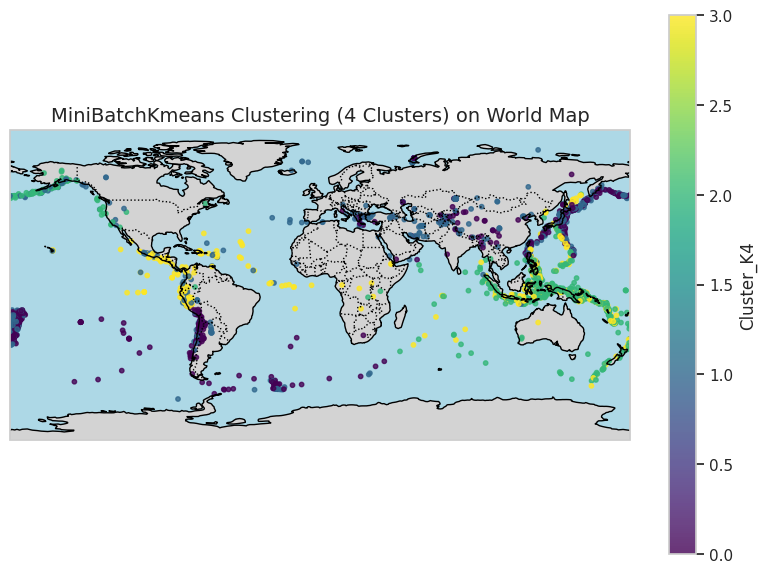

In [ ]:
df_original['Cluster_K4'] = df['Cluster_K4']
latitude_col = 'Latitude'
longitude_col = 'Longitude'

def plot_clusters_on_map(df, cluster_column, title, ax):
    ax.set_global()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    scatter = ax.scatter(
        df[longitude_col],
        df[latitude_col],
        c=df[cluster_column],
        cmap='viridis',
        s=10,
        alpha=0.8,
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title, fontsize=14)
    return scatter

fig, ax = plt.subplots(figsize=(10, 7), subplot_kw={'projection': ccrs.PlateCarree()})
scatter = plot_clusters_on_map(df_original, 'Cluster_K4', 'MiniBatchKmeans Clustering (4 Clusters) on World Map', ax)

plt.colorbar(scatter, ax=ax, label='Cluster_K4')